## Trying out ideas for a flexible sliding window function

In [1]:
import os
tmp = os.getcwd()
os.chdir(tmp.split("jmspack")[0] + "jmspack")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jmspack.utils import (
                              apply_scaling
                          )

from jmspack.utils import JmsColors

In [3]:
os.chdir(tmp)

In [64]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import cross_decomposition, decomposition

In [5]:
if "jms_style_sheet" in plt.style.available:
    _ = plt.style.use("jms_style_sheet")

In [6]:
def change_profile(x, window_size):
#     window_size = 5
#     x=ts
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        window_mean = x.iloc[window_begin: window_begin + window_size].mean()
        window_sum = x.iloc[window_begin: window_begin + window_size].sum()
        
#         current_cp_df = x.iloc[window_begin: window_begin + window_size] - window_mean

        current_cp_df = (x.iloc[window_begin: window_begin + window_size] - window_sum) / window_size
        cp_df = pd.concat([cp_df, current_cp_df])
        
    return cp_df[0]

In [7]:
def win_PCA(x, window_size):
#     window_size = 5
#     x=ts
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        current_cp_df = pd.DataFrame(PCA(n_components=None).fit_transform(x.iloc[window_begin: window_begin + window_size])).iloc[:, 0]
        cp_df = pd.concat([cp_df, current_cp_df])
        
    return cp_df[0]

In [45]:
def summary_window_FUN(x: pd.DataFrame, window_size: int = 7, user_func=decomposition.PCA, kwargs: dict = {}):
    window_range = np.arange(0, len(x)-window_size, window_size)

    cp_df = pd.DataFrame()
    for window_begin in window_range:
        current_cp_df = pd.DataFrame(user_func(n_components=None, **kwargs).fit_transform(x.iloc[window_begin: window_begin + window_size])).iloc[:, 0]
        cp_df = pd.concat([cp_df, current_cp_df])

    return cp_df.rename(columns={0: f"windowed_{user_func.__name__}"}).reset_index(drop=True)

In [9]:
def mad(x):
    return np.fabs(x - x.mean()).mean()

In [10]:
ts_name = "lorenz"

In [11]:
df = pd.read_csv("../datasets/time_series_dataset.csv", index_col=0).head(500)

In [12]:
ts_df = pd.read_csv("../datasets/time_series_dataset.csv", index_col=0)[[ts_name]].head(500)

In [13]:
ts_df[ts_name]

0      -0.156058
1      -0.071057
2       0.004560
3       0.072342
4       0.133683
         ...    
495   -13.234793
496   -13.758987
497   -14.212115
498   -14.576715
499   -14.836584
Name: lorenz, Length: 500, dtype: float64

In [14]:
# ts_df[ts_name].rolling(window=3).apply(lambda x: (x - x.sum())/ x.shape[0])
# ts_df[ts_name].rolling(window=3).apply(change_profile_apply)
ts_df[ts_name].rolling(window=3).apply(mad)

0           NaN
1           NaN
2      0.054582
3      0.048670
4      0.043757
         ...   
495    0.401457
496    0.373237
497    0.333670
498    0.282412
499    0.219793
Name: lorenz, Length: 500, dtype: float64

In [15]:
plot_df = (ts_df
 .assign(**{f"{ts_name}_cp": change_profile(x=ts_df[ts_name], window_size=5),
            f"{ts_name}_mad": lambda d: d[ts_name].rolling(window=5).apply(mad),
            f"{ts_name}_mean": lambda d: d[ts_name].rolling(window=25).mean(),
            f"{ts_name}_scaled_sum": lambda d: d.pipe(apply_scaling)[ts_name].rolling(window=25).sum(),
#             f"all_df_PCA": win_PCA(df, window_size=5).append(pd.Series(np.repeat(np.nan, 5))).reset_index(drop=True)
           })
           .reset_index()
 .melt(id_vars="index")
           
)

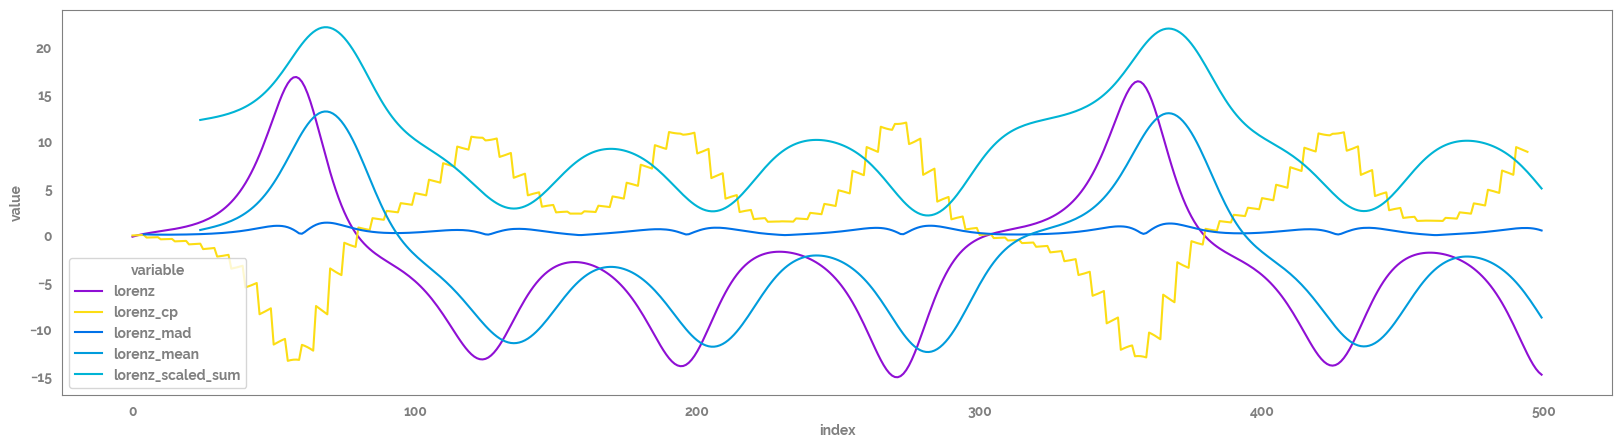

In [16]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=plot_df,
                x="index",
                y="value",
                hue="variable")

In [17]:
# win_LDA(df, window_size=5)

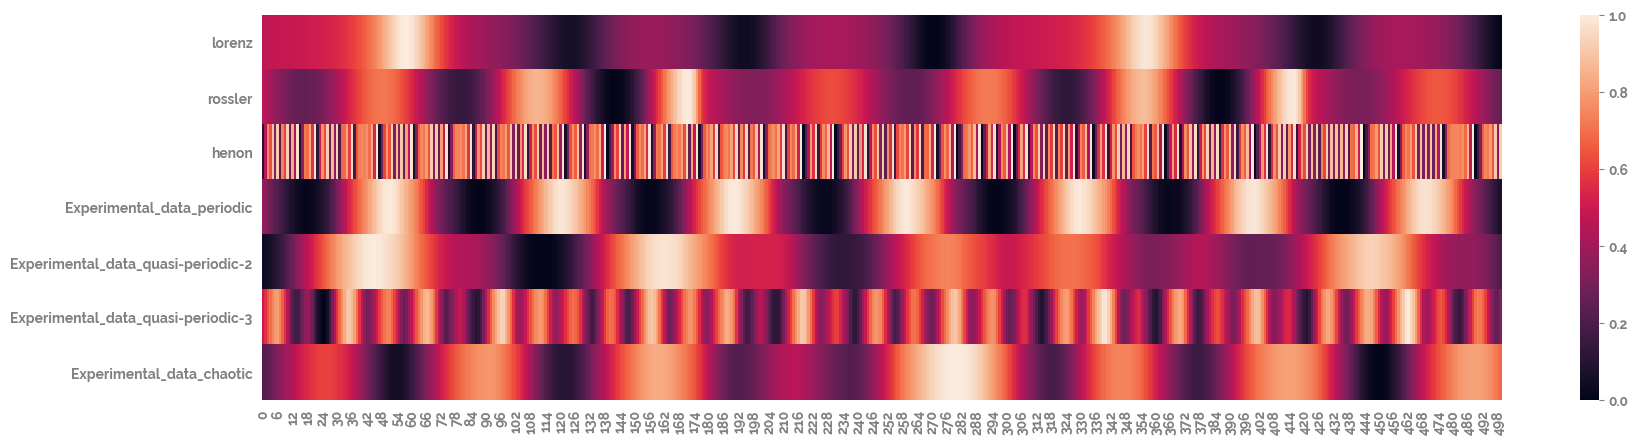

In [18]:
_ = plt.figure(figsize=(20, 5))
_ = sns.heatmap(df.pipe(apply_scaling).T)

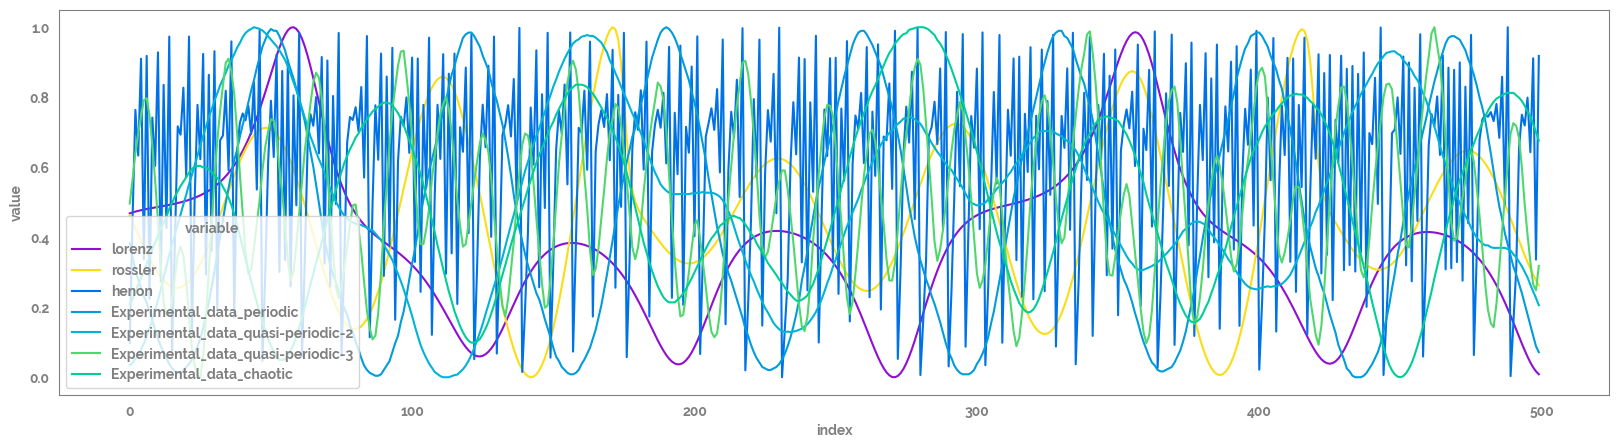

In [19]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=df.pipe(apply_scaling)
                 .reset_index()
                 .melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable")

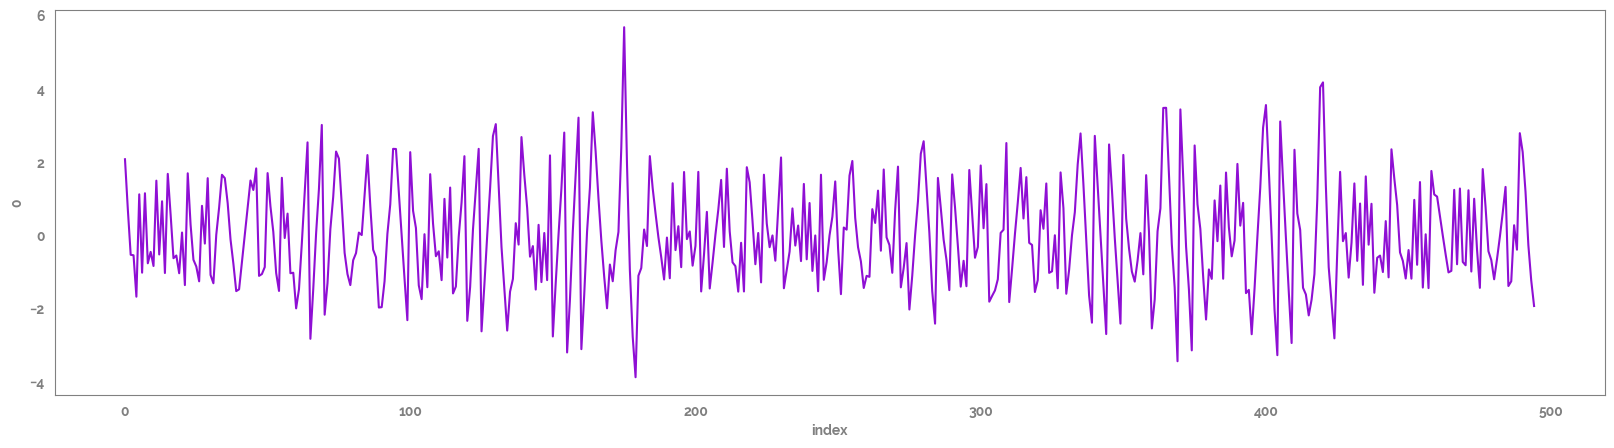

In [20]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=win_PCA(df, window_size=5).reset_index(drop=True).reset_index(),
                x="index",
                y=0)

In [74]:
[x for x in sklearn.utils.all_estimators(type_filter="transformer") if ".decomposition" in str(x[1])]

[('DictionaryLearning',
  sklearn.decomposition._dict_learning.DictionaryLearning),
 ('FactorAnalysis', sklearn.decomposition._factor_analysis.FactorAnalysis),
 ('FastICA', sklearn.decomposition._fastica.FastICA),
 ('IncrementalPCA', sklearn.decomposition._incremental_pca.IncrementalPCA),
 ('KernelPCA', sklearn.decomposition._kernel_pca.KernelPCA),
 ('LatentDirichletAllocation',
  sklearn.decomposition._lda.LatentDirichletAllocation),
 ('MiniBatchDictionaryLearning',
  sklearn.decomposition._dict_learning.MiniBatchDictionaryLearning),
 ('MiniBatchSparsePCA', sklearn.decomposition._sparse_pca.MiniBatchSparsePCA),
 ('NMF', sklearn.decomposition._nmf.NMF),
 ('PCA', sklearn.decomposition._pca.PCA),
 ('SparseCoder', sklearn.decomposition._dict_learning.SparseCoder),
 ('SparsePCA', sklearn.decomposition._sparse_pca.SparsePCA),
 ('TruncatedSVD', sklearn.decomposition._truncated_svd.TruncatedSVD)]

In [ ]:
# [('DictionaryLearning', sklearn.decomposition._dict_learning.DictionaryLearning), #FUNCTIONS
#  ('FactorAnalysis', sklearn.decomposition._factor_analysis.FactorAnalysis), #FUNCTIONS
#  ('FastICA', sklearn.decomposition._fastica.FastICA), #FUNCTIONS
#  ('IncrementalPCA', sklearn.decomposition._incremental_pca.IncrementalPCA), #FUNCTIONS 
#  ('KernelPCA', sklearn.decomposition._kernel_pca.KernelPCA), #FUNCTIONS
#  ('LatentDirichletAllocation', sklearn.decomposition._lda.LatentDirichletAllocation), #not ok
#  ('MiniBatchDictionaryLearning', sklearn.decomposition._dict_learning.MiniBatchDictionaryLearning), #not ok - too computationally intensive
#  ('MiniBatchSparsePCA', sklearn.decomposition._sparse_pca.MiniBatchSparsePCA), #ok as long as not min max scaled
#  ('NMF', sklearn.decomposition._nmf.NMF), #ok as long as no negatives
#  ('PCA', sklearn.decomposition._pca.PCA), #FUNCTIONS
#  ('SparseCoder', sklearn.decomposition._dict_learning.SparseCoder), #not ok
#  ('SparsePCA', sklearn.decomposition._sparse_pca.SparsePCA), #not ok
#  ('TruncatedSVD', sklearn.decomposition._truncated_svd.TruncatedSVD)] #not ok

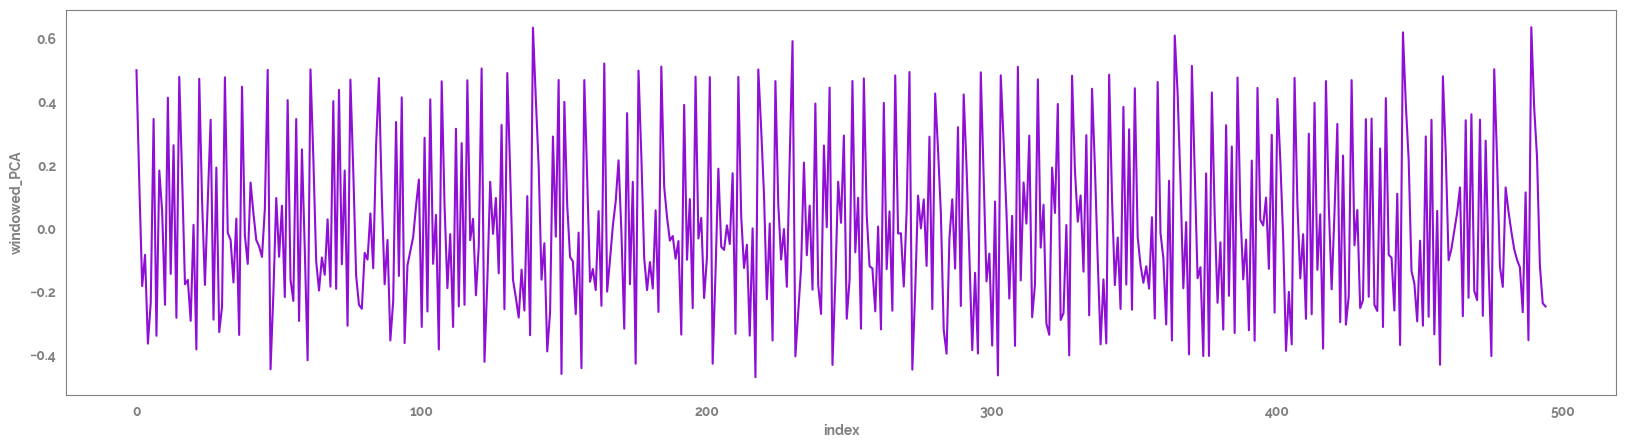

In [107]:
window_function = decomposition.PCA
scale_data=True
if scale_data:
    _ = plt.figure(figsize=(20, 5))
    _ = sns.lineplot(data=summary_window_FUN(df.pipe(apply_scaling), window_size=5, user_func=window_function, kwargs={"random_state":42}).reset_index(),
                    x="index",
                    y=f"windowed_{window_function.__name__}")
else:
    _ = plt.figure(figsize=(20, 5))
    _ = sns.lineplot(data=summary_window_FUN(df, window_size=5, user_func=window_function).reset_index(),
                    x="index",
                    y=f"windowed_{window_function.__name__}")

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   lorenz                              500 non-null    float64
 1   rossler                             500 non-null    float64
 2   henon                               500 non-null    float64
 3   Experimental_data_periodic          500 non-null    float64
 4   Experimental_data_quasi-periodic-2  500 non-null    float64
 5   Experimental_data_quasi-periodic-3  500 non-null    float64
 6   Experimental_data_chaotic           500 non-null    float64
dtypes: float64(7)
memory usage: 47.4 KB


In [101]:
decomps_list = [decomposition.DictionaryLearning, 
                decomposition.FactorAnalysis, 
                decomposition.FastICA, 
                # decomposition.IncrementalPCA, 
                decomposition.KernelPCA, 
                decomposition.NMF,
                decomposition.PCA
                ]

In [106]:
dec_df = pd.concat([summary_window_FUN(df.pipe(apply_scaling), window_size=5, user_func=window_function, kwargs={"random_state":42}) for window_function in decomps_list], axis=1).reset_index()

/opt/miniconda3/envs/jmspack/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/opt/miniconda3/envs/jmspack/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/opt/miniconda3/envs/jmspack/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/opt/miniconda3/envs/jmspack/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the

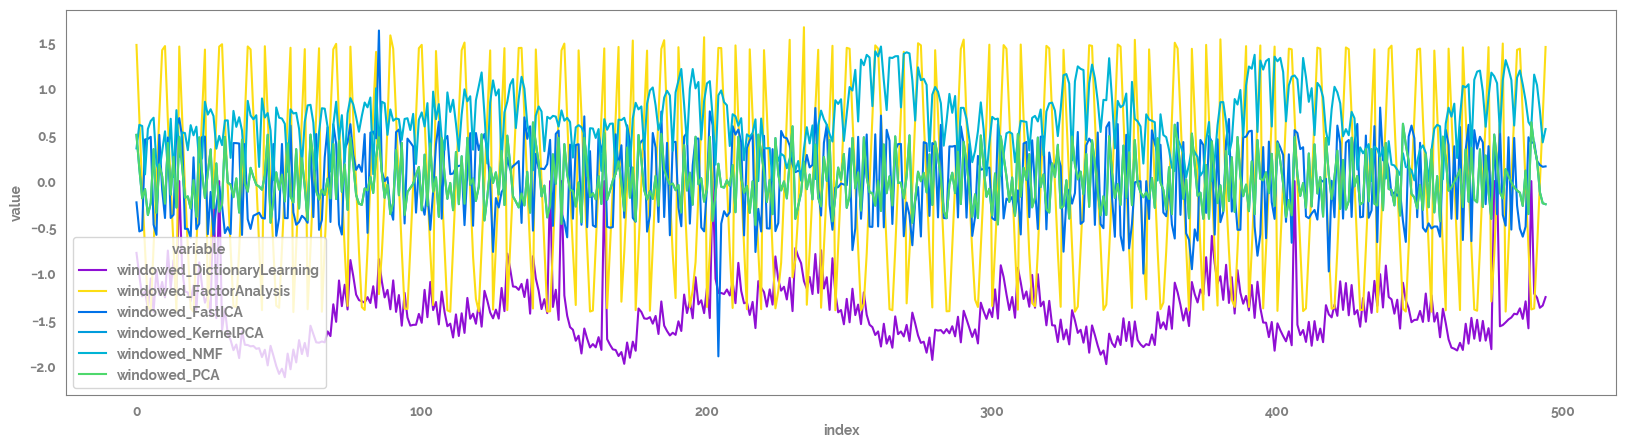

In [109]:
_ = plt.figure(figsize=(20, 5))
_ = sns.lineplot(data=dec_df.melt(id_vars="index"),
                x="index",
                y="value",
                hue="variable")